## RPPA association

This notebook examines the association between mutations in the identified UPS driver genes and protein expression from Reverse Phase Protein Arrays (RPPA).

In [1]:
# import needed python packages
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import utils

First, read in the data.

In [2]:
df = pd.read_csv('data/rppa/rppa_association.txt', sep='\t')

Next, plot the significant hits that reach a minimum effect size.

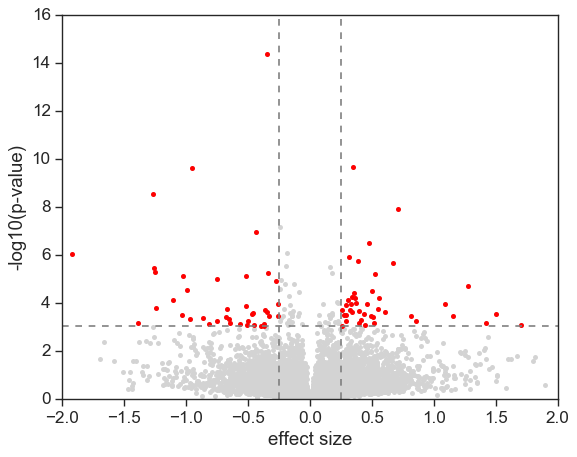

In [3]:
def get_pval_threshold(data, qval_thresh=0.1):
    return data[data['qvalue']<=qval_thresh]['-log10(p-value)'].min()

df['-log10(p-value)'] = -np.log10(df['pvalue'])
with sns.axes_style('ticks'), sns.plotting_context('notebook', font_scale=1.4):
    # plot all points
    sns.scatterplot(df['beta'], df['-log10(p-value)'], color='lightgray', linewidth=0)
    
    # different color for significant ones
    is_high_beta = df['beta'].abs()>0.25
    is_signif = df['qvalue']<=0.1
    signif = df[is_high_beta & is_signif]
    sns.scatterplot(signif['beta'], signif['-log10(p-value)'], color='red', linewidth=0)
    
    # plot the thresholds
    plt.axvline(0.25, color='gray', linestyle='--')
    plt.axvline(-0.25, color='gray', linestyle='--')
    pval_thresh = get_pval_threshold(df)
    plt.axhline(pval_thresh, color='gray', linestyle='--')
    plt.xlabel('effect size')
    
    plt.ylim(bottom=0)
    plt.xlim(-2, 2)

We next examine which UPS genes contain the most significant associations.

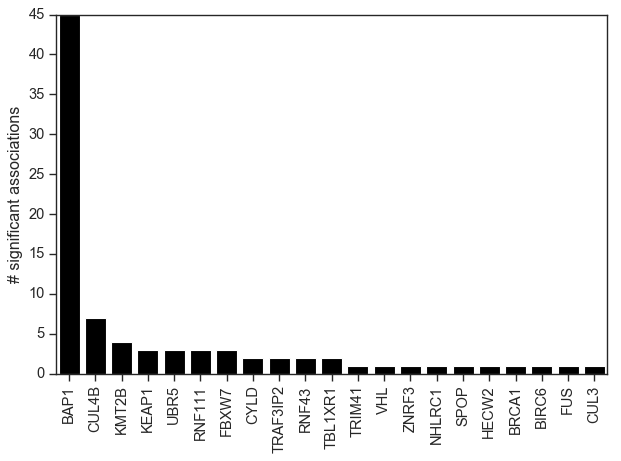

In [4]:
gene_cts = signif['gene'].value_counts()
with sns.axes_style('ticks'), sns.plotting_context('notebook', font_scale=1.2):
    sns.barplot(gene_cts.index, gene_cts, color='black')
    plt.ylabel('# significant associations')
    ax = plt.gca()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.tight_layout()

### CCNE1 analysis

In [31]:
# read data
mut_df = pd.read_csv('data/misc/mc3.v0.2.8.PUBLIC.code.filtered.small.maf', sep='\t')
rppa_df = pd.read_csv('data/rppa/TCGA-RPPA-pancan-clean.txt', sep='\t')

# filter on head and neck
rppa_df = rppa_df[rppa_df['TumorType']=='HNSC']
mut_df = mut_df[mut_df['CODE']=='HNSC']

# annotate FBXW7
mut_df['FBXW7'] = 0
mut_df.loc[mut_df['Hugo_Symbol']=='FBXW7', 'FBXW7'] = 1

# add patient IDs
rppa_df['PatientID'] = rppa_df['SampleID'].str[:12]
mut_df['PatientID'] = mut_df['Tumor_Sample_Barcode'].str[:12]

In [35]:
fbxw7 = mut_df.groupby('PatientID')['FBXW7'].max()
fbxw7 = fbxw7.apply(lambda x: 'mutant' if x else 'wildtype').reset_index()

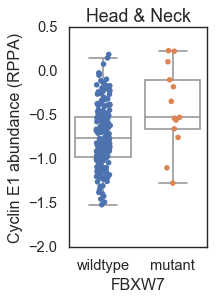

In [50]:
plot_df = pd.merge(rppa_df, fbxw7, on='PatientID', how='left')
with sns.axes_style('white'), sns.plotting_context('notebook', font_scale=1.2):
    sns.boxplot(x='FBXW7', y='CYCLINE1', data=plot_df, color='white', fliersize=0)
    sns.stripplot(x='FBXW7', y='CYCLINE1', 
                  data=plot_df)
    plt.ylabel('Cyclin E1 abundance (RPPA)')
    plt.gcf().set_size_inches(3, 4)
    plt.title('Head & Neck', size=16)
    plt.tight_layout()
    plt.savefig('figures/fbxw7_cycline1.pdf')

### Supplementary table

In [15]:
supp_table = signif.sort_values('pvalue')
supp_table[supp_table.columns[:-1]].to_excel('tables/TableS10.xlsx', sheet_name='rppa', index=False)